# Load libraries

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns 
# For interpretability
import shap
import matplotlib.pyplot as plt

In [32]:
# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load data

In [33]:
df = pd.read_csv("../data/raw/ibm_attrition_plus_succession_reordered.csv", sep=";")


In [34]:
df.head(10)

,EmployeeNumber,EmployeeCount,Age,Gender,MaritalStatus,Education,EducationField,Over18,StandardHours,BusinessTravel,...,EnvironmentSatisfaction,WorkLifeBalance,JobInvolvement,OverTime,Attrition,TargetRole,LeadershipScore,CulturalFitScore,PotentialRating,SuccessorReady
0,1,1,41,Female,Single,2,Life Sciences,Y,80,Travel_Rarely,...,2,1,3,Yes,Yes,Sales Manager,4,2,Low,0
1,2,1,49,Male,Married,1,Life Sciences,Y,80,Travel_Frequently,...,3,3,2,No,No,Research Manager,5,2,High,1
2,4,1,37,Male,Single,2,Other,Y,80,Travel_Rarely,...,4,3,2,Yes,Yes,Sr Technician,3,3,High,0
3,5,1,33,Female,Married,4,Life Sciences,Y,80,Travel_Frequently,...,4,3,3,Yes,No,Research Manager,5,5,Low,0
4,7,1,27,Male,Married,1,Medical,Y,80,Travel_Rarely,...,1,3,3,No,No,Sr Technician,5,2,High,0
5,8,1,32,Male,Single,2,Life Sciences,Y,80,Travel_Frequently,...,4,2,3,No,No,Sr Technician,2,4,Medium,0
6,10,1,59,Female,Married,3,Medical,Y,80,Travel_Rarely,...,3,2,4,Yes,No,Sr Technician,3,2,Medium,0
7,11,1,30,Male,Divorced,1,Life Sciences,Y,80,Travel_Rarely,...,4,3,3,No,No,Sr Technician,3,5,High,0
8,12,1,38,Male,Single,3,Life Sciences,Y,80,Travel_Frequently,...,4,3,2,No,No,VP Manufacturing,3,5,Medium,0
9,13,1,36,Male,Married,3,Medical,Y,80,Travel_Rarely,...,3,2,3,No,No,Team Lead,5,4,Low,0


In [35]:
df.shape


(1470, 35)

In [36]:
print(df.columns.tolist())

['EmployeeNumber', 'EmployeeCount', 'Age', 'Gender', 'MaritalStatus', 'Education', 'EducationField', 'Over18', 'StandardHours', 'BusinessTravel', 'Department', 'JobRole', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'TotalWorkingYears', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'PerformanceRating', 'PercentSalaryHike', 'StockOptionLevel', 'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'OverTime', 'Attrition', 'TargetRole', 'LeadershipScore', 'CulturalFitScore', 'PotentialRating', 'SuccessorReady']


# Misiing Values

In [37]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EmployeeNumber           1470 non-null   int64 
 1   EmployeeCount            1470 non-null   int64 
 2   Age                      1470 non-null   int64 
 3   Gender                   1470 non-null   object
 4   MaritalStatus            1470 non-null   object
 5   Education                1470 non-null   int64 
 6   EducationField           1470 non-null   object
 7   Over18                   1470 non-null   object
 8   StandardHours            1470 non-null   int64 
 9   BusinessTravel           1470 non-null   object
 10  Department               1470 non-null   object
 11  JobRole                  1470 non-null   object
 12  JobLevel                 1470 non-null   int64 
 13  MonthlyIncome            1470 non-null   int64 
 14  YearsAtCompany           1470 non-null  

# Convert binary/categorical to uniform types
# Convert Yes/No and other fields to numeric for modeling
# Convert categorical succession flags (e.g., PotentialRating) to numeric

In [38]:

binary_cols = ['OverTime', 'SuccessorReady']
for col in binary_cols:
    print(f"\nUnique values in {col}: {df[col].unique()}")


df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})


succession_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['PotentialRating'] = df['PotentialRating'].map(succession_map)


Unique values in OverTime: ['Yes' 'No']

Unique values in SuccessorReady: [0 1]


# TARGET VARIABLE DISTRIBUTION


Target Variable Distribution (Attrition):
Attrition
0    1233
1     237
Name: count, dtype: int64


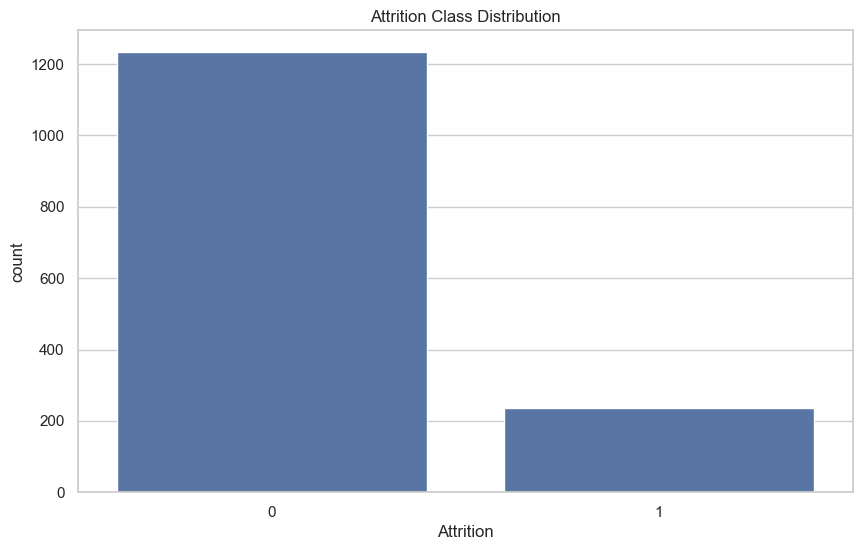

In [39]:
print("\nTarget Variable Distribution (Attrition):")
print(df['Attrition'].value_counts())
sns.countplot(data=df, x='Attrition')
plt.title('Attrition Class Distribution')
plt.show()

# Drop columns that have a single unique value or no impact

In [40]:

cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18']
df.drop(columns=cols_to_drop, inplace=True)

print("\nRemaining Columns After Cleanup:")
print(df.columns.tolist())


Remaining Columns After Cleanup:
['EmployeeNumber', 'Age', 'Gender', 'MaritalStatus', 'Education', 'EducationField', 'BusinessTravel', 'Department', 'JobRole', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'TotalWorkingYears', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'PerformanceRating', 'PercentSalaryHike', 'StockOptionLevel', 'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'OverTime', 'Attrition', 'TargetRole', 'LeadershipScore', 'CulturalFitScore', 'PotentialRating', 'SuccessorReady']


#  FEATURE ENGINEERING

In [26]:
# Bucket 'YearsAtCompany' into tenure groups
def tenure_bucket(years):
    if years < 2:
        return '0-2 years'
    elif years < 5:
        return '2-5 years'
    elif years < 10:
        return '5-10 years'
    else:
        return '10+ years'

In [25]:
df['TenureBucket'] = df['YearsAtCompany'].apply(tenure_bucket)

In [24]:
# Create a 'HighPotentialFlag' based on multiple criteria
df['HighPotentialFlag'] = np.where(
    (df['PotentialRating'] == 2) &
    (df['LeadershipScore'] >= 4) &
    (df['CulturalFitScore'] >= 4),
    1, 0
)

In [23]:
# Flag employees at risk with no ready successor
df['CriticalRiskFlag'] = np.where(
    (df['Attrition'] == 1) & (df['SuccessorReady'] == 0),
    1, 0
)

In [41]:
# Create TenureBucket from YearsAtCompany
df['TenureBucket'] = pd.cut(
    df['YearsAtCompany'],
    bins=[0, 3, 7, 20],
    labels=['Short', 'Medium', 'Long']
)

# Create HighPotentialFlag — mock logic (you can adjust thresholds)
df['HighPotentialFlag'] = ((df['PerformanceRating'] >= 3) & (df['JobLevel'] <= 2)).astype(int)

# Create CriticalRiskFlag — mock logic (adjust based on your business logic)
df['CriticalRiskFlag'] = ((df['Attrition'] == 'Yes') & (df['JobLevel'] >= 3)).astype(int)


In [42]:
# Display new feature summary
print("\nFeature Engineering - New Columns Preview:")
print(df[['YearsAtCompany', 'TenureBucket', 'HighPotentialFlag', 'CriticalRiskFlag']].head())


Feature Engineering - New Columns Preview:
   YearsAtCompany TenureBucket  HighPotentialFlag  CriticalRiskFlag
0               6       Medium                  1                 0
1              10         Long                  1                 0
2               0          NaN                  1                 0
3               8         Long                  1                 0
4               2        Short                  1                 0


# EXPLORATORY DATA ANALYSIS (EDA)

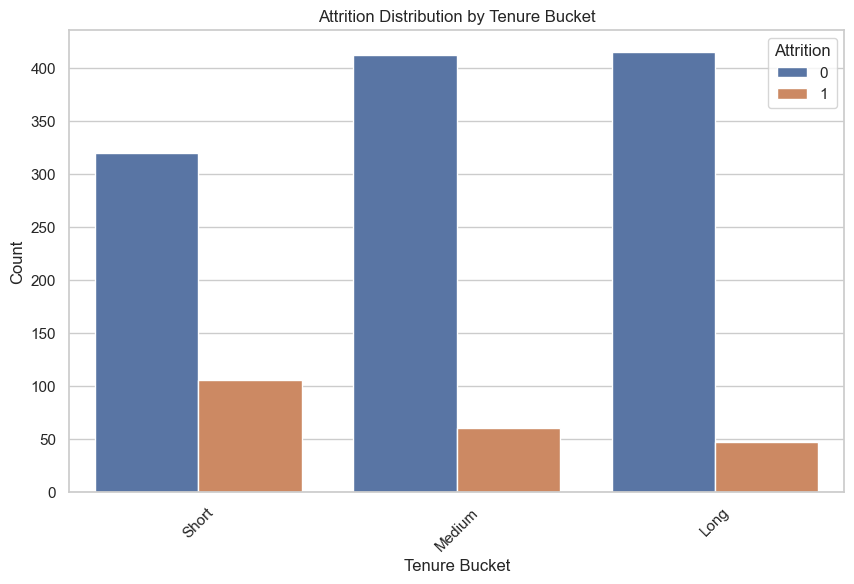

In [43]:
# Attrition by Tenure Bucket
sns.countplot(data=df, x='TenureBucket', hue='Attrition')
plt.title('Attrition Distribution by Tenure Bucket')
plt.xlabel('Tenure Bucket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

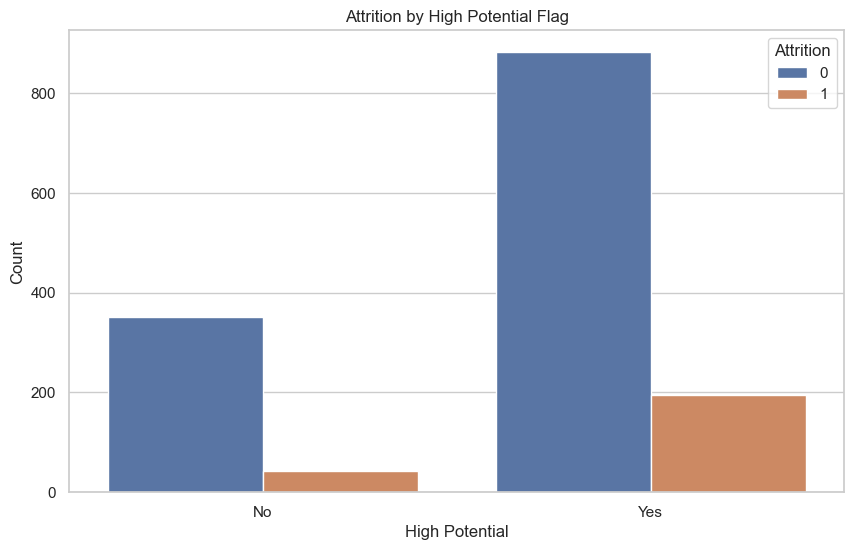

In [44]:
# Attrition vs HighPotentialFlag
sns.countplot(data=df, x='HighPotentialFlag', hue='Attrition')
plt.title('Attrition by High Potential Flag')
plt.xlabel('High Potential')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

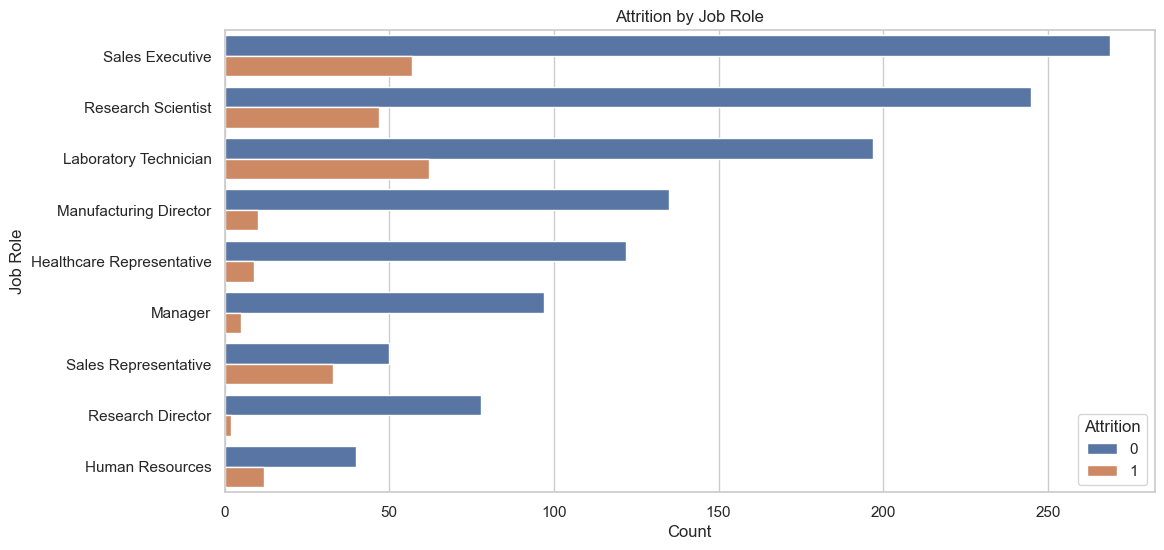

In [45]:
# Attrition vs Job Role
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='JobRole', hue='Attrition')
plt.title('Attrition by Job Role')
plt.ylabel('Job Role')
plt.xlabel('Count')
plt.show()

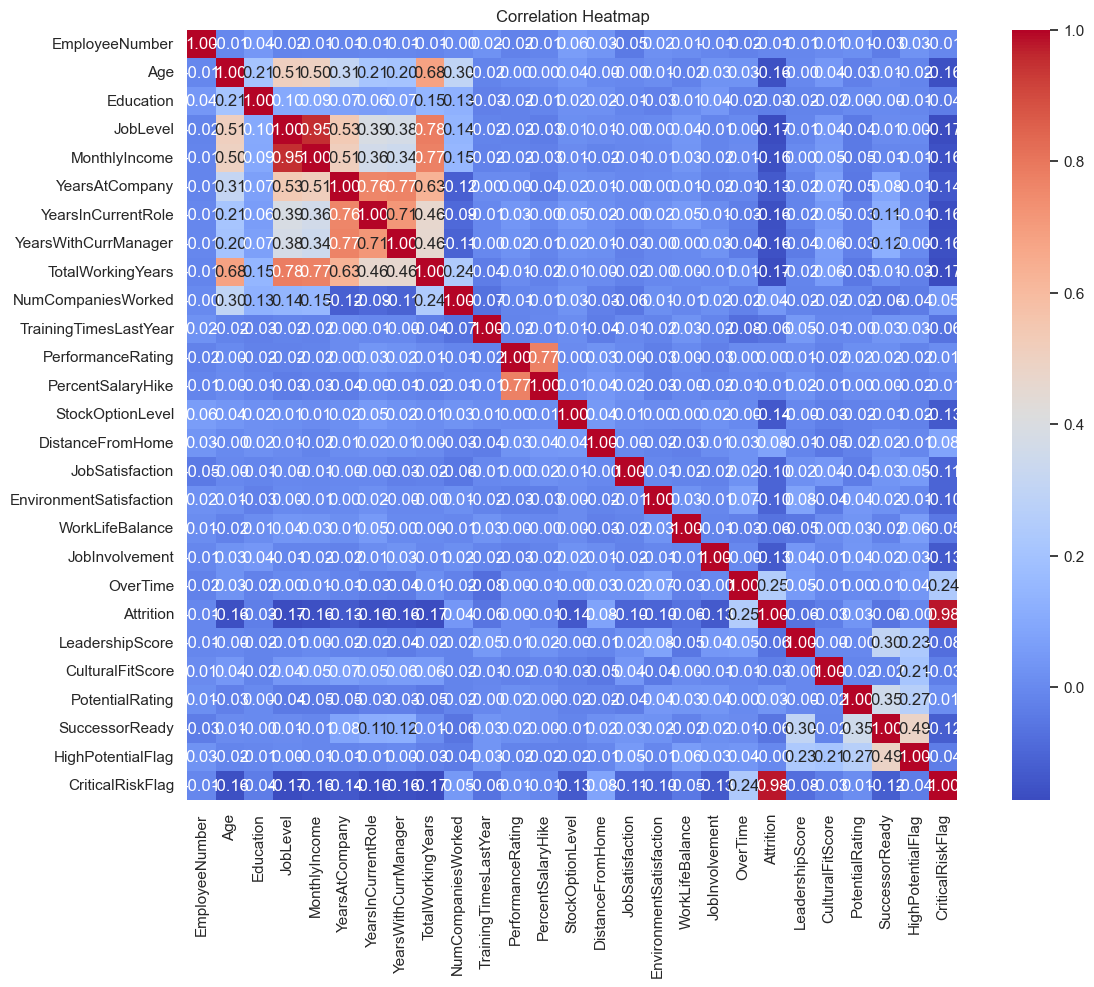

In [19]:
# Correlation Heatmap (only numeric features)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

#  DATA PREPROCESSING FOR MODELING

In [46]:
# One-hot encode categorical variables
df_model = pd.get_dummies(df, columns=['Gender', 'MaritalStatus', 'EducationField', 'BusinessTravel', 'Department', 'JobRole', 'TenureBucket', 'TargetRole'], drop_first=True)

In [47]:
# Define feature set and target variable
X = df_model.drop(columns=['Attrition'])
y = df_model['Attrition']

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [49]:
# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [51]:
print("\nData shapes after preprocessing:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Data shapes after preprocessing:
X_train: (1176, 56)
X_test: (294, 56)
y_train: (1176,)
y_test: (294,)


#  MODEL TRAINING AND EVALUATION

In [52]:
# Standardize only numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Reassign to avoid SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [53]:
# Filter numeric columns and scale them
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

In [54]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.47      0.17      0.25        47

    accuracy                           0.84       294
   macro avg       0.66      0.57      0.58       294
weighted avg       0.80      0.84      0.80       294


Confusion Matrix:


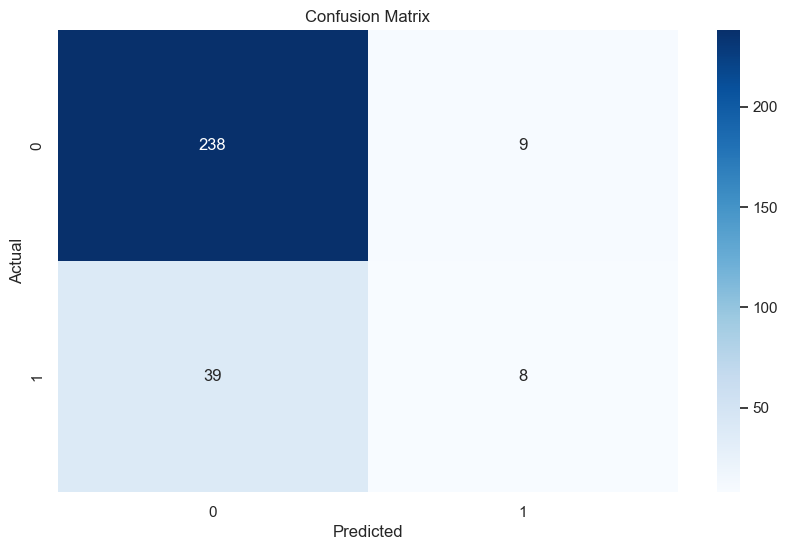


ROC AUC Score: 0.7694


In [55]:
# Keep only numeric columns in both training and testing sets
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Standardize numeric columns
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# ✅ Save model for Streamlit app
import joblib
joblib.dump(rf_model, "../model/rf_model.pkl")

# Predict on test data
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.47      0.17      0.25        47

    accuracy                           0.84       294
   macro avg       0.66      0.57      0.58       294
weighted avg       0.80      0.84      0.80       294


Confusion Matrix:


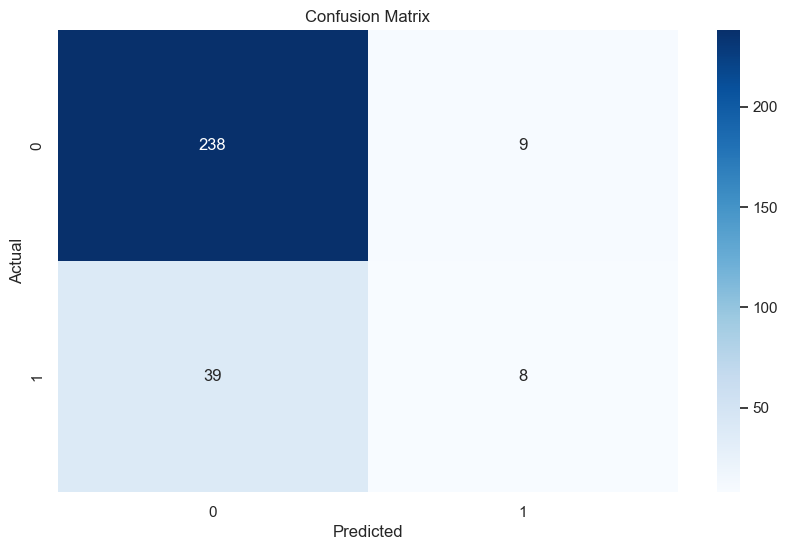


ROC AUC Score: 0.7694


In [56]:
# Predict on test data
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")

# MODEL INTERPRETABILITY WITH SHAP

In [57]:
X_test_scaled[numeric_cols].to_numpy()


array([[ 7.99411540e-01, -1.41682587e+00, -8.82151750e-01, ...,
        -2.93040230e-01,  6.11417841e-01,  0.00000000e+00],
       [ 3.83997807e-01,  7.63191429e-01, -1.85533229e+00, ...,
         3.41250074e+00,  6.11417841e-01,  0.00000000e+00],
       [-6.72053972e-01, -6.53819813e-01,  9.10287922e-02, ...,
        -2.93040230e-01, -1.63554272e+00,  0.00000000e+00],
       ...,
       [ 1.19647366e+00, -1.08815489e-01,  2.03738988e+00, ...,
        -2.93040230e-01,  6.11417841e-01,  0.00000000e+00],
       [ 7.09321815e-01,  2.07120181e+00, -8.82151750e-01, ...,
        -2.93040230e-01,  6.11417841e-01,  0.00000000e+00],
       [-1.04242284e+00,  1.85375620e-04,  9.10287922e-02, ...,
        -2.93040230e-01,  6.11417841e-01,  0.00000000e+00]],
      shape=(294, 26))

<Figure size 1000x600 with 0 Axes>

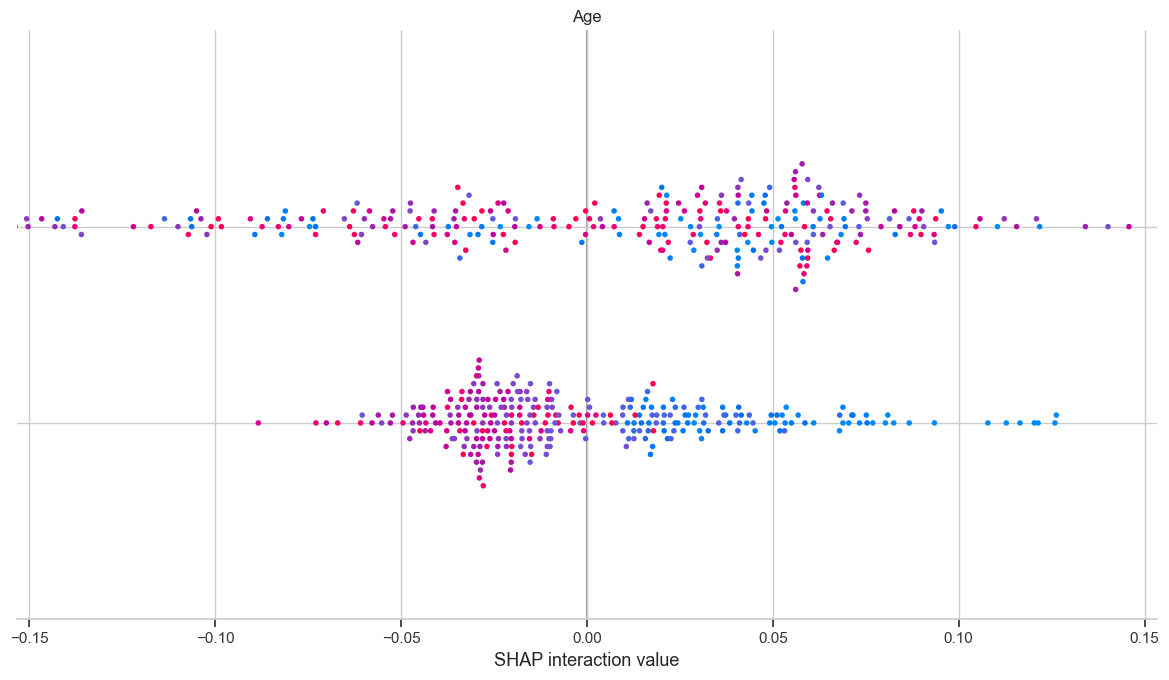

<Figure size 1000x600 with 0 Axes>

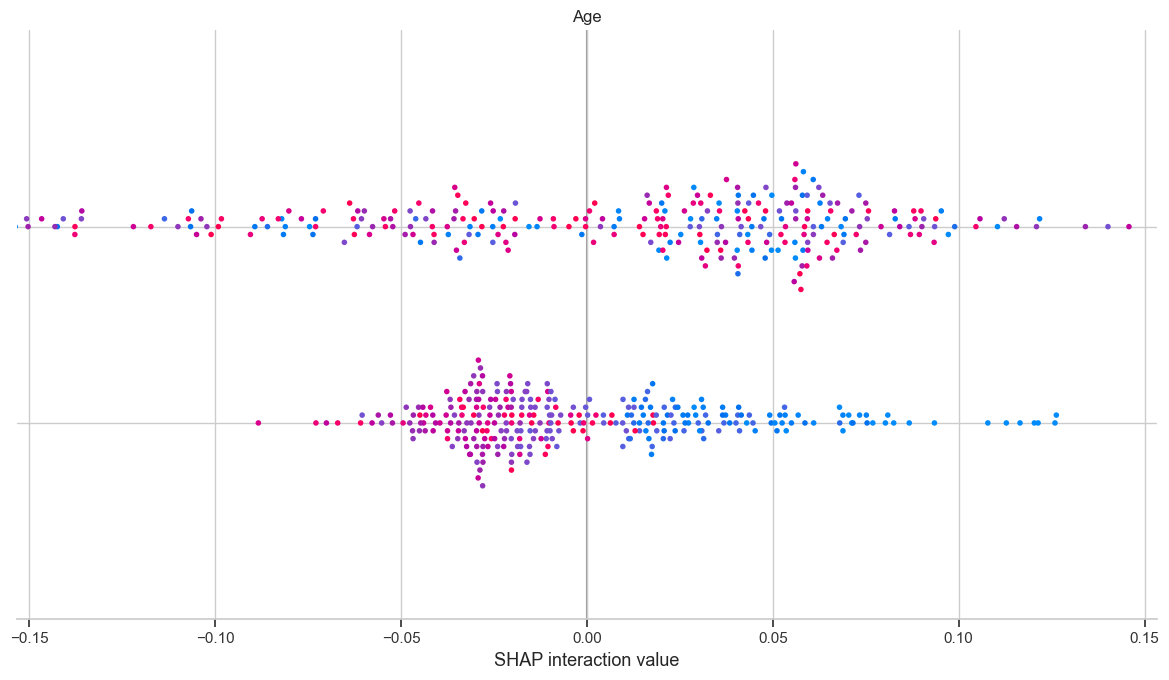

In [58]:
# Convert to array and ensure correct alignment with training columns
X_test_array = X_test_scaled[numeric_cols].to_numpy()

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_array)

# Safely extract SHAP values for binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_to_plot = shap_values[1]  # Class 1 (Attrition=Yes)
    expected_value = explainer.expected_value[1]
else:
    shap_vals_to_plot = shap_values
    expected_value = explainer.expected_value

# Summary plot (global feature importance)
shap.summary_plot(shap_vals_to_plot, X_test_array, feature_names=numeric_cols.tolist(), plot_type="bar")

# Beeswarm plot for detailed impact
shap.summary_plot(shap_vals_to_plot, X_test_array, feature_names=numeric_cols.tolist())



MODEL TRAINING & Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.47      0.17      0.25        47

    accuracy                           0.84       294
   macro avg       0.66      0.57      0.58       294
weighted avg       0.80      0.84      0.80       294


Confusion Matrix:


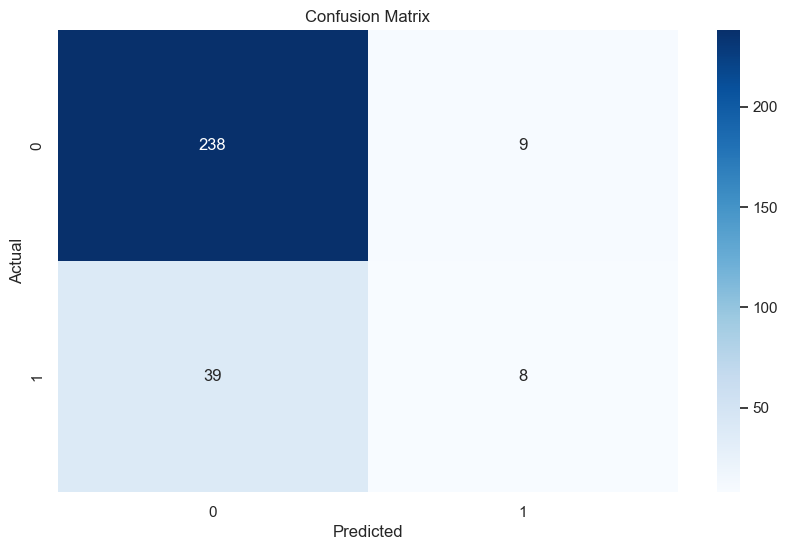


ROC AUC Score: 0.7694


In [59]:
 

# 📌 11. MODEL TRAINING AND EVALUATION

# Filter numeric columns and scale them
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled[numeric_cols], y_train)

# Predict on test data
y_pred = rf_model.predict(X_test_scaled[numeric_cols])
y_proba = rf_model.predict_proba(X_test_scaled[numeric_cols])[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")

#  11.1 CORRELATION WITH ATTRITION


Top Features Most Correlated with Attrition:
MonthlyIncome         0.064085
JobLevel              0.055401
HighPotentialFlag    -0.053602
DistanceFromHome     -0.050666
SuccessorReady       -0.045312
Age                   0.042609
WorkLifeBalance       0.036890
LeadershipScore      -0.034495
Education            -0.032207
NumCompaniesWorked    0.031152
Name: Attrition, dtype: float64


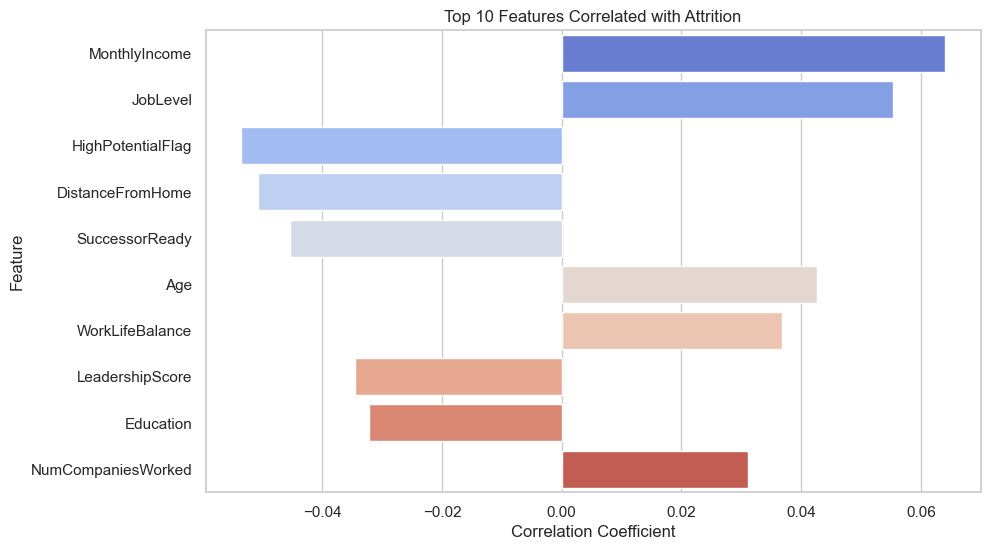

In [60]:
# Ensure 'Attrition' is numeric for correlation
X_train_scaled_with_target = X_train_scaled.copy()
y_train_numeric = y_train.map({'Yes': 1, 'No': 0}) if y_train.dtype == 'object' else y_train
X_train_scaled_with_target['Attrition'] = y_train_numeric.reset_index(drop=True)

# Compute correlations
correlations = X_train_scaled_with_target.corr()['Attrition'].drop('Attrition').sort_values(key=abs, ascending=False)

print("\nTop Features Most Correlated with Attrition:")
print(correlations.head(10))

# Visualize top 10 correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.head(10).values, y=correlations.head(10).index, hue=correlations.head(10).index, palette="coolwarm", legend=False)
plt.title("Top 10 Features Correlated with Attrition")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()


 CORRELATION COMPARISON BY GROUP

Departments included in correlation analysis:
['Sales' 'Research & Development' 'Human Resources']
Top Correlated Features Grouped by Department:
PotentialRating            0.998976
EnvironmentSatisfaction   -0.974389
PercentSalaryHike         -0.973487
DistanceFromHome           0.886075
WorkLifeBalance            0.866363
Education                  0.826828
LeadershipScore            0.702314
TotalWorkingYears         -0.593916
PerformanceRating         -0.524672
OverTime                  -0.523128
dtype: float64


/Users/Devika/Desktop/IronHack/finalproject/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/Devika/Desktop/IronHack/finalproject/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


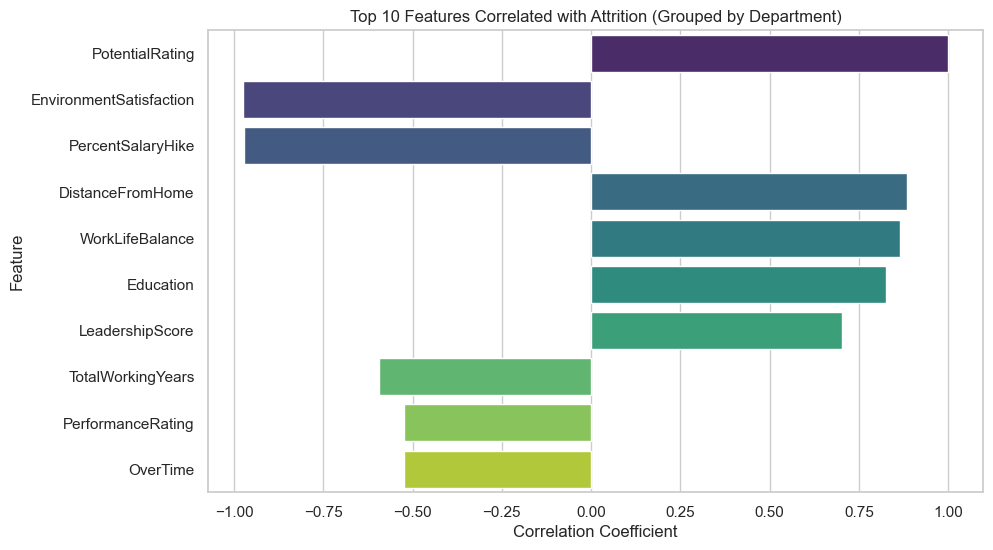

In [61]:

# 📌 11.2 CORRELATION COMPARISON BY DEPARTMENT

# Merge Department back with X_train
y_train_numeric = y_train.map({'Yes': 1, 'No': 0}) if y_train.dtype == 'object' else y_train
X_train_with_dept = X_train.copy()
X_train_with_dept['Department'] = df.loc[X_train.index, 'Department'].values
X_train_with_dept['Attrition'] = y_train_numeric.values

# Display departments used in analysis
print("Departments included in correlation analysis:")
print(X_train_with_dept['Department'].unique())

# Compute mean attrition by department
dept_mean_attrition = X_train_with_dept.groupby('Department')['Attrition'].mean()

# Compute mean feature values per department
dept_mean_features = X_train_with_dept.groupby('Department')[numeric_cols].mean().replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

# Correlate mean feature values with mean attrition per department
dept_corr = dept_mean_features.corrwith(dept_mean_attrition).sort_values(key=abs, ascending=False)

print("Top Correlated Features Grouped by Department:")
print(dept_corr.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=dept_corr.head(10).values, y=dept_corr.head(10).index, hue=dept_corr.head(10).index, palette="viridis", legend=False)
plt.title("Top 10 Features Correlated with Attrition (Grouped by Department)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

In [35]:
# 📌 12. MODEL INTERPRETABILITY WITH SHAP
import streamlit as st
import shap
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Ensure X_sample has only numeric features used in model
X_sample = pd.DataFrame(X_test_scaled[numeric_cols], columns=numeric_cols)

# ✅ Generate SHAP values using TreeExplainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

# ✅ Pick correct SHAP values for binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_to_plot = shap_values[1]  # Class 1 (Attrition = Yes)
    expected_value = explainer.expected_value[1]
else:
    shap_vals_to_plot = shap_values
    expected_value = explainer.expected_value

# ✅ Ensure shapes match
assert shap_vals_to_plot.shape == X_sample.shape, f"Mismatch: SHAP {shap_vals_to_plot.shape}, X {X_sample.shape}"

# ✅ SHAP Summary Bar Plot
st.subheader("🧠 Feature Importance (SHAP)")
fig_bar, ax = plt.subplots()
shap.summary_plot(shap_vals_to_plot, X_sample, plot_type="bar", show=False)
st.pyplot(fig_bar)

# ✅ SHAP Beeswarm Plot
fig_swarm, ax = plt.subplots()
shap.summary_plot(shap_vals_to_plot, X_sample, show=False)
st.pyplot(fig_swarm)



AssertionError: Mismatch: SHAP (294, 26, 2), X (294, 26)

In [6]:
df_model = df.dropna()  # handle missing values if any
X = df_model.drop(columns=["Attrition"])  # Features
y = df_model["Attrition"]  # Target


NameError: name 'df' is not defined